In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.idl import readsav
from scipy.signal import find_peaks
import pickle 
from astropy.io import fits
from spectral_cube import SpectralCube
from astropy import units as u
import numpy.ma as ma
from astropy.stats import sigma_clip
import matplotlib.patheffects as path_effects
from matplotlib.gridspec import GridSpec
import mpl_toolkits.axes_grid1.axes_grid as axes_grid
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
#from mpl_toolkits.axes_grid.colorbar import colorbar
from matplotlib.patches import Ellipse
import math
from matplotlib import cm
from astropy.wcs import WCS
import scipy
import scipy.ndimage as ndi
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import pkg_resources
from specutils import Spectrum1D, SpectralRegion
from astropy.modeling import models
from specutils.spectra import Spectrum1D
from specutils.fitting import fit_lines
from __future__ import print_function
import pyspeckit
import pylab as pl

In [43]:
def fourfourgrid(globule = 'GlobB', source = '13CO'):
    
    path = globule + '_' + source + '.image.pbcor.fits'
    cube = fits.open(path)
    data = cube[0].data
    header = cube[0].header

    data1 = data[0,:,:,:]

    ra_start = header["CRVAL1"]
    ra_inc = header["CDELT1"]

    channels = np.arange(header["NAXIS1"]) - (header["CRPIX1"])+1

    ra = ra_start + (ra_inc * channels)
    ra = np.array(ra, dtype = float)

    dec_start = header["CRVAL2"]
    dec_inc = header["CDELT2"]

    channels1 = np.arange(header["NAXIS2"]) - (header["CRPIX2"])+1

    dec = dec_start + (dec_inc * channels1)
    dec = np.array(dec, dtype = float)

    freq_start = header["CRVAL3"]
    freq_inc = header["CDELT3"]

    freq_channels = np.arange(header["NAXIS3"])

    frequency = freq_start + (freq_inc * freq_channels)
    frequency = np.array(frequency, dtype = float)
    velocity = 3e8*(-(frequency/header["RESTFRQ"])+1)/1000
    vel_inc = 3e8*(-(header["CDELT3"]/header["RESTFRQ"]))/1000
    #print(velocity)

    if globule == 'GlobB':
        x1 = round(header["CRPIX1"]-(ra_start-337.434)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.427)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.818)/dec_inc)-2
        y2 = round(header["CRPIX2"]-(dec_start+20.812)/dec_inc)-2
    elif globule == 'GlobC':
        x1 = round(header["CRPIX1"]-(ra_start-337.409)/ra_inc)-1
        x2 = round(header["CRPIX1"]-(ra_start-337.406)/ra_inc)-1
        y1 = round(header["CRPIX2"]-(dec_start+20.801)/dec_inc)-1
        y2 = round(header["CRPIX2"]-(dec_start+20.796)/dec_inc)-1

    data2 = data1[:, :, np.arange(x1, x2)]
    data3 = data2[:, np.arange(y1, y2), :]
    
    if source == '12CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.03
    elif source == '13CO':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.1
    elif source == 'C18O':
        if globule == 'GlobB':
            d = 0.28
        else:
            d = 0.15
    elif source == 'CCH':
        if globule == 'GlobB':
            d = 0.25
        else:
            d = 0.15
    elif source == 'CCH_32':
        if globule == 'GlobB':
            d = 0.15
        else:
            d = 0.08
    elif source == 'HC3N':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.25
    elif source == 'HCN':
        if globule == 'GlobB':
            d = 0.06
        else:
            d = 0.08
    elif source == 'HCN_32':
        if globule == 'GlobB':
            d = 0.065
        else:
            d = 0.04
    elif source == 'HCOp':
        if globule == 'GlobB':
            d = 0.08
        else:
            d = 0.1
    elif source == 'HCOp_32':
        if globule == 'GlobB':
            d = 0.1
        else:
            d = 0.08
    elif source == 'HNC':
        if globule == 'GlobB':
            d = 0.3
        else:
            d = 0.08
    elif source == 'HNC_32':
        if globule == 'GlobB':
            d = 0.2
        else:
            d = 0.12
            
    integrated = np.sum(data3[:, :, :], axis = 0)
    
    extent = [ra[x1],ra[x2],dec[y1],dec[y2]]

    max_val = np.nanmax(integrated)
    
    a = [x for x in range(len(data1[:, 0, 0]))]
    array = []
    for i in range(len(a)):
        if np.nanmax(data3[a[i], :, :]) > d*max_val:
            array.append(a[i])
    
    moment0 = np.sum(data3[array, :, :], axis = 0)
    
    mom0 = np.ma.array(moment0)*abs(vel_inc)
    maximum = np.nanmax(mom0)
    
    intermediate = np.sum(data1[array,:,:] * velocity[array,np.newaxis,np.newaxis], axis=0)
    
    intermediate_x = intermediate[:, np.arange(x1, x2)]
    intermediate_y = intermediate_x[np.arange(y1, y2), :]
    moment1 = intermediate_y/moment0

    #Adding in the mask
    sigma_mask = sigma_clip(moment0, sigma=3, maxiters=None, cenfunc='mean')
    newmask = (moment0 < np.amax(sigma_mask))
    #maskednoise = np.ma.masked_array(moment0, mask = newmask)
    
    mom1 = np.ma.array(moment1, mask=newmask)
    
    rng=range(len(velocity))
    spectrum = []
    for i in rng:
        spectrum += [np.nansum(data1[i, :, :])]
        
    pv_integrated = np.nansum(data3[array, :, :], axis = 2)
    #print(integrated.shape)
    
    pv_extent = [velocity[array[-1]], velocity[array[0]], dec[y1], dec[y2]]
    
    tr = scipy.ndimage.rotate(pv_integrated, 270)

    levels = np.linspace(0, np.nanmax(integrated), 15)
    
    fig, axs = plt.subplots(2, 2)
    axs[0, 0].imshow(mom0, origin= 'lower', cmap='inferno', extent=extent)
    axs[0, 0].set_title('Moment 0')
    axs[0, 0].fig(figsize=[4, 4])
    #axs[0, 0].xticks()
    #axs[0, 0].yticks()
    axs[0, 0].set_facecolor("black")
    #axs[0, 0].xlabel('RA (deg)')
    #axs[0, 0].ylabel('DEC(deg)')
    #axs[0, 0].colorbar(label = r'Integrated Instensity (Jy/Beam km/s)', fraction=0.07, pad=0.04)
    #axs[0, 0].clim(0.0, maximum)
    
    axs[0, 1].imshow(mom1, origin='lower', cmap='bwr', extent=extent)
    axs[0, 1].set_title('Moment 1')
    axs[0, 1].figure(figsize=[4, 4])
    #axs[0, 0].xticks()
    #axs[0, 0].yticks()
    #axs[0, 0].xlabel('RA (deg)')
    #axs[0, 0].ylabel('DEC(deg)')
    #axs[0, 0].colorbar(label = r'Velocity (km s$^{-1}$)', fraction=0.07, pad=0.04)
    #axs[0, 0].clim(0.0, maximum)
    
    axs[1, 0].plot(velocity, spectrum)
    axs[1, 0].set_title('Spectrum')
    axs[1, 0].figure(figsize=[4, 4])
    
    axs[1, 1].contour(tr, levels = levels[1:15], cmap = 'afmhot', origin = 'lower', extent = pv_extent)
    axs[1, 1].set_title('PV Diagram')
    axs[1, 1].figure(figsize=[4, 4])
    
    plt.suptitle(source, fontsize = 20)

Input data contains invalid values (NaNs or infs), which were automatically clipped.
invalid value encountered in less


AttributeError: 'AxesSubplot' object has no attribute 'fig'

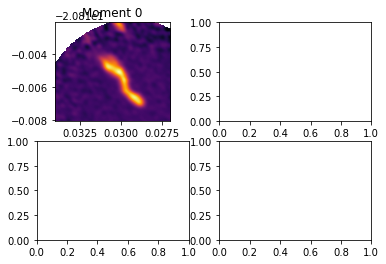

In [44]:
fourfourgrid(globule = 'GlobB', source = '13CO')